# Vector Autoregressive (VAR) Model Example

This notebook demonstrates four types of VAR models
* Reduced-Form VAR
* Structural VAR (SVAR)
* VAR with Exogenous Variables (VARX)
* Bayesian VAR (BVAR)—using real-world economic data from FRED.

We use data from FRED:
- Real GDP Growth (GDPC1, quarterly, percent change)
- Inflation Rate (CPIAUCSL, quarterly, percent change)
- Federal Funds Rate (FEDFUNDS, quarterly average) as an exogenous variable for VARX.

We estimate the models, compute impulse response functions (IRFs), and visualize results.

In [16]:
# libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import pymc as pm
import pytensor.tensor as pt
from numpy.linalg import matrix_rank
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from datetime import datetime
# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# define parameters
start = datetime(2000, 1, 1)
end = datetime(2024, 12, 31)
variables = ['GDPC1', 'CPIAUCSL', 'FEDFUNDS']
endog_variables = ['GDP_Growth', 'Inflation']
exog_variables = ['FEDFUNDS']

In [3]:
# define functions
def compute_J_like_statsmodels(endog, B):
    """
    Replicate statsmodels' internal Jacobian computation for svar_type='B'
    given endog data and restriction matrix B.
    """
    k = B.shape[0]
    
    # Step 1: Fit reduced-form VAR to get Sigma_u
    var_res = VAR(endog).fit(maxlags=4)  # same lags as you plan to use
    Sigma_u = var_res.sigma_u
    print("Reduced-form residual covariance matrix Σ_u:\n", Sigma_u)
    
    # Step 2: Build B mask
    B_mask = np.isnan(B)
    
    # Step 3: Vectorize restrictions (statsmodels uses column-stacking)
    free_params = np.where(B_mask.flatten())[0]
    print(f"Free parameter positions in B (vectorized): {free_params}")
    
    # Step 4: Build Jacobian J (simplified from statsmodels' _compute_J)
    # For svar_type='B', J is constructed from derivatives of vech(Sigma_u) w.r.t. free params
    # This is a simplified illustrative version:
    if free_params.size == 0:
        return np.array([])
    
    J = []
    for idx in free_params:
        # Create a matrix E with 1 in free param location, 0 elsewhere
        E = np.zeros_like(B)
        E.flat[idx] = 1.0
        
        # Derivative of Sigma_u = B^{-1} * B^{-T} wrt that parameter
        try:
            Binv = np.linalg.inv(np.nan_to_num(B, nan=0.0) + np.eye(k)*B_mask)
        except np.linalg.LinAlgError:
            print("B (with guesses) is singular.")
            return np.array([])
        
        deriv = -Binv @ E @ Binv @ Binv.T - Binv @ Binv.T @ E.T @ Binv.T
        deriv_sym = deriv[np.tril_indices(k)]
        J.append(deriv_sym)
    
    J = np.column_stack(J)
    print("Jacobian J shape:", J.shape)
    print("Jacobian J:\n", J)
    
    return J

def check_svar_identification(A=None, B=None):
    """
    Check order and rank conditions for SVAR identification.

    Parameters
    ----------
    A : np.ndarray or None
        Structural matrix A. None means identity.
    B : np.ndarray or None
        Structural matrix B. None means identity.

    Returns
    -------
    None (prints results)
    """
    if A is None and B is None:
        raise ValueError("You must provide at least one of A or B.")
    
    # Infer k from first non-None matrix
    if A is not None:
        k = A.shape[0]
    else:
        k = B.shape[0]
    
    if A is None:
        A = np.eye(k)
    if B is None:
        B = np.eye(k)

    # Count free parameters (np.nan entries)
    free_A = np.isnan(A).sum()
    free_B = np.isnan(B).sum()
    total_free = free_A + free_B

    # Order condition
    order_needed = k*(k-1)//2
    print(f"Variables (k): {k}")
    print(f"Free parameters: {total_free}")
    print(f"Minimum needed by order condition: {order_needed}")

    if total_free >= order_needed:
        print("✅ Order condition may be satisfied.")
    else:
        print("❌ Order condition NOT satisfied.")

    # Rank condition check: build Jacobian-like matrix of restrictions
    # Following the approach of statsmodels: mask fixed vs free params
    mask_A = np.isnan(A) if A is not None else np.zeros((k, k), dtype=bool)
    mask_B = np.isnan(B) if B is not None else np.zeros((k, k), dtype=bool)

    # Vectorize masks (column stack) for A and B
    mask_vec = np.hstack([mask_A.flatten(), mask_B.flatten()])
    J = np.eye(mask_vec.size)[:, mask_vec]  # simplification: identity subset
    
    rankJ = matrix_rank(J)
    print(f"Rank of restrictions Jacobian: {rankJ}")
    print(f"Full column rank needed: {mask_vec.sum()}")

    if rankJ == mask_vec.sum():
        print("✅ Rank condition satisfied.")
    else:
        print("❌ Rank condition NOT satisfied.")

get data, preprocess and visualize

In [4]:
# Download
df = web.DataReader(variables, 'fred', start, end)

# Reset index so date is a column
df = df.reset_index()

# Group every 3 rows
data = (
    df.groupby(df.index // 3)
      .agg({ 'DATE': 'last',
             'GDPC1': 'mean',
             'CPIAUCSL': 'mean',
             'FEDFUNDS': 'mean'
           })
)
# Calculate GDP Growth and Inflation
data['GDP_Growth'] = data['GDPC1'].pct_change() * 100
data['Inflation'] = data['CPIAUCSL'].pct_change() * 100

# Put DATE back as index
data = data.set_index('DATE')
data

,GDPC1,CPIAUCSL,FEDFUNDS,GDP_Growth,Inflation
DATE,,,,,
2000-03-01,13878.147,170.100000,5.676667,NaN,NaN
2000-06-01,14130.908,171.433333,6.273333,1.821288,0.783853
2000-09-01,14145.312,173.000000,6.520000,0.101933,0.913864
2000-12-01,14229.765,174.233333,6.473333,0.597039,0.712909
2001-03-01,14183.120,175.900000,5.593333,-0.327799,0.956572
...,...,...,...,...,...
2023-12-01,22960.600,308.158333,5.330000,0.788673,0.691408
2024-03-01,23053.545,310.974333,5.330000,0.404802,0.913816
2024-06-01,23223.906,313.095667,5.330000,0.738980,0.682157


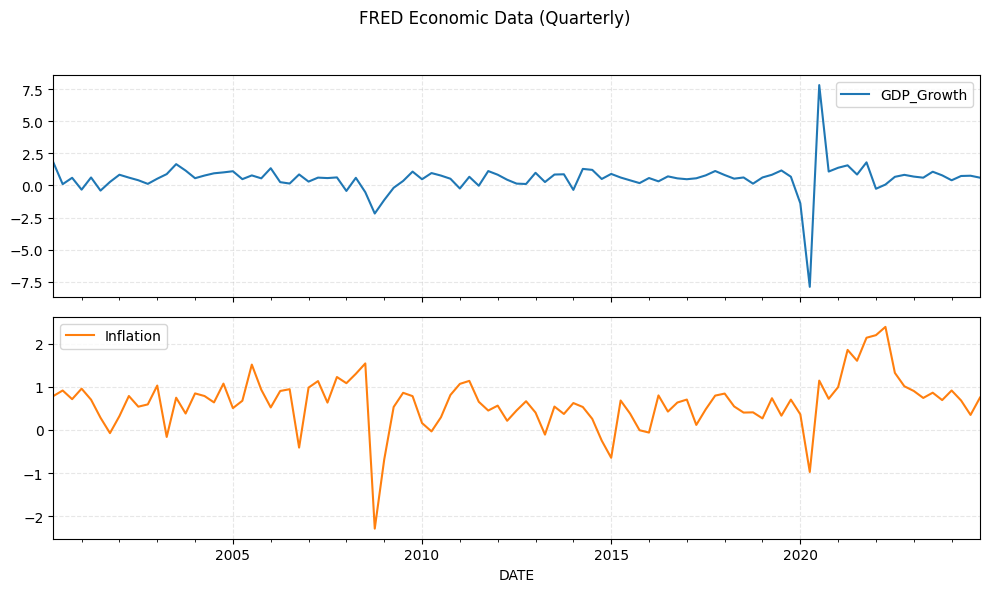

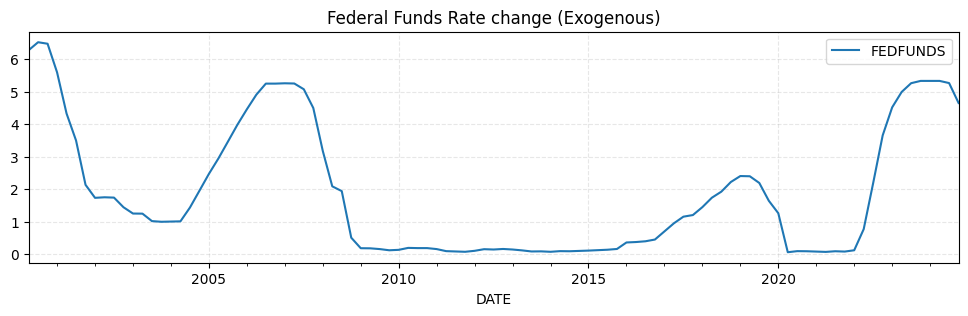

In [5]:
# Select endogenous variables (GDP_Growth, Inflation) and exogenous (FEDFUNDS)
endog_data = data[['GDP_Growth', 'Inflation']].dropna()
exog_data = data[['FEDFUNDS']].dropna().reindex(endog_data.index, method='ffill')

# Plot endogenous variables with grid
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)
endog_data.plot(subplots=True, ax=axes)
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.3)  # Add dashed grid with transparency
plt.suptitle("FRED Economic Data (Quarterly)")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot exogenous variable with grid
fig, ax = plt.subplots(figsize=(12, 3))
exog_data.plot(ax=ax)
ax.grid(True, linestyle='--', alpha=0.3)  # Add dashed grid with transparency
ax.set_title("Federal Funds Rate change (Exogenous)")
plt.show()

# Reduced-Form VAR

In [6]:
# Fit a reduced-form VAR model with GDP Growth and Inflation as endogenous variables.
var_model = VAR(endog_data)
var_results = var_model.fit(maxlags=4, ic='aic')
var_results.summary()

c:\Users\manuz\Desktop\Adm\Projects\VAR_Python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Aug, 2025
Time:                     22:01:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.610820
Nobs:                     98.0000    HQIC:                 -0.705069
Log likelihood:          -234.427    FPE:                   0.463456
AIC:                    -0.769083    Det(Omega_mle):        0.436333
--------------------------------------------------------------------
Results for equation GDP_Growth
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.666493         0.182590            3.650           0.000
L1.GDP_Growth        -0.184150         0.106921           -1.722           0.085
L1.Inflation         -0.057467         0.220584        

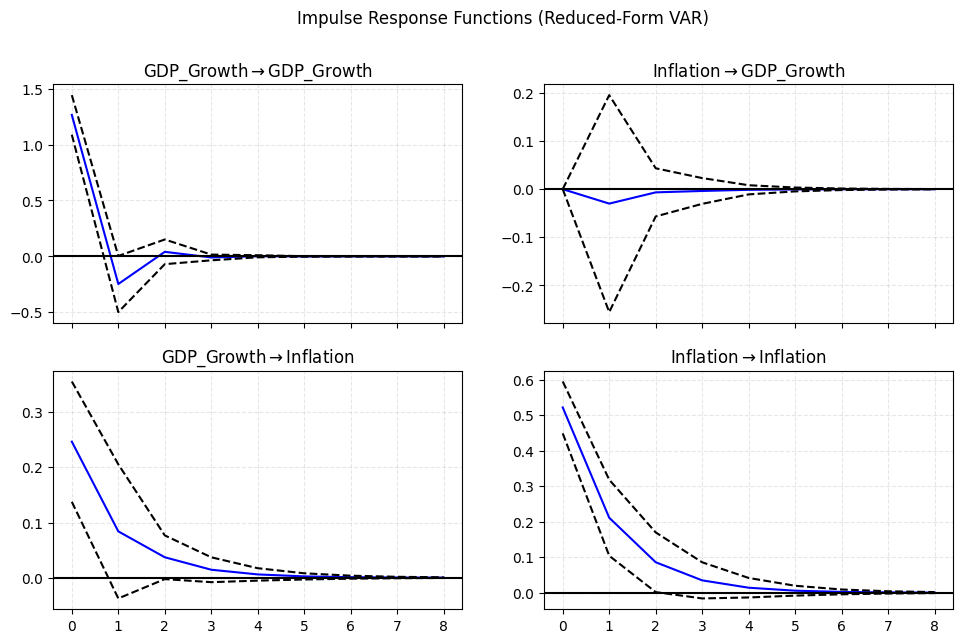

In [7]:
# Impulse Response Functions - one-standard-deviation shock to each endogenous variable
irf = var_results.irf(8)
fig = irf.plot(orth=True, figsize=(10, 6))
for ax in fig.axes:
    ax.grid(True, linestyle='--', alpha=0.3)
plt.suptitle("Impulse Response Functions (Reduced-Form VAR)", y=1.05)
plt.show()

# Structural VAR (SVAR)

Fit an SVAR model with a lower-triangular contemporaneous matrix (B):

Assume GDP Growth affects Inflation contemporaneously, but not vice versa.

### Understanding the SVAR `B` Matrix Restrictions

The `B` matrix in the Structural Vector Autoregression (SVAR) model specifies the contemporaneous relationships between the structural shocks and the endogenous variables. It relates the reduced-form residuals ($u_t$) to the structural shocks ($\epsilon_t$) via the equation:

$$ u_t = B \epsilon_t $$

where:
- $u_t$: Vector of reduced-form residuals for `GDP_Growth` and `Inflation`.
- $\epsilon_t$: Vector of structural shocks (orthogonal, with zero correlation).
- $B$: Matrix of contemporaneous effects of structural shocks on the variables.

### Interpreting the `B` Matrix

The `B` matrix is lower triangular, with the structure:

$$
B = \begin{bmatrix}
1 & 0 \\
E & 1
\end{bmatrix}
$$

- **Rows**: Correspond to the endogenous variables in the order `[GDP_Growth, Inflation]`.
- **Columns**: Correspond to the structural shocks: `[GDP_Growth shock, Inflation shock]`.
- **Diagonal (1)**: Normalizes the variance of each structural shock.
- **Off-diagonal (`0` and `E`)**: Specify contemporaneous relationships, where `E` is a free parameter.

### Key Restrictions

- $B[0,1] = 0$: Imposes that the structural shock to `Inflation` ($\epsilon_{\text{Inflation}}$) has **no contemporaneous effect** on `GDP_Growth`. An unexpected change (shock) in `Inflation` does not immediately affect `GDP_Growth` within the same period (quarter).
- $B[1,0] = E$: Allows the structural shock to `GDP_Growth` ($\epsilon_{\text{GDP}}$) to have a **contemporaneous effect** on `Inflation`. The parameter `E` is estimated by the model, meaning `Inflation` can respond immediately to `GDP_Growth` shocks.

### Direction of Relationships

The lower triangular structure implies a **recursive identification** (Cholesky-like):
- **GDP_Growth $\to$ Inflation**: The free parameter $B[1,0] = E$ allows a `GDP_Growth` shock to contemporaneously affect `Inflation` (e.g., higher GDP growth may increase inflation due to demand pressures).
- **Inflation $\to$ GDP_Growth**: The restriction $B[0,1] = 0.0$ means an `Inflation` shock does **not** contemporaneously affect `GDP_Growth`, assuming `GDP_Growth` responds to `Inflation` shocks with a lag.

In [8]:
# Define restriction matrix for SVAR (lower triangular B matrix)
B = np.array([[1.0, 0.0],
              ["E", 1.0]], dtype=object)

# Fit model
svar_model = SVAR(endog_data, svar_type='B', B=B)
svar_results = svar_model.fit(maxlags=4)

svar_results.k_exog_user = 0
svar_results.summary()

c:\Users\manuz\Desktop\Adm\Projects\VAR_Python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Sun, 03, Aug, 2025
Time:                     22:01:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0672144
Nobs:                     95.0000    HQIC:                 -0.355578
Log likelihood:          -225.421    FPE:                   0.576969
AIC:                    -0.551107    Det(Omega_mle):        0.481430
--------------------------------------------------------------------
Results for equation GDP_Growth
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.871824         0.250453            3.481           0.000
L1.GDP_Growth        -0.233467         0.119233           -1.958           0.050
L1.Inflation          0.077532         0.264436        

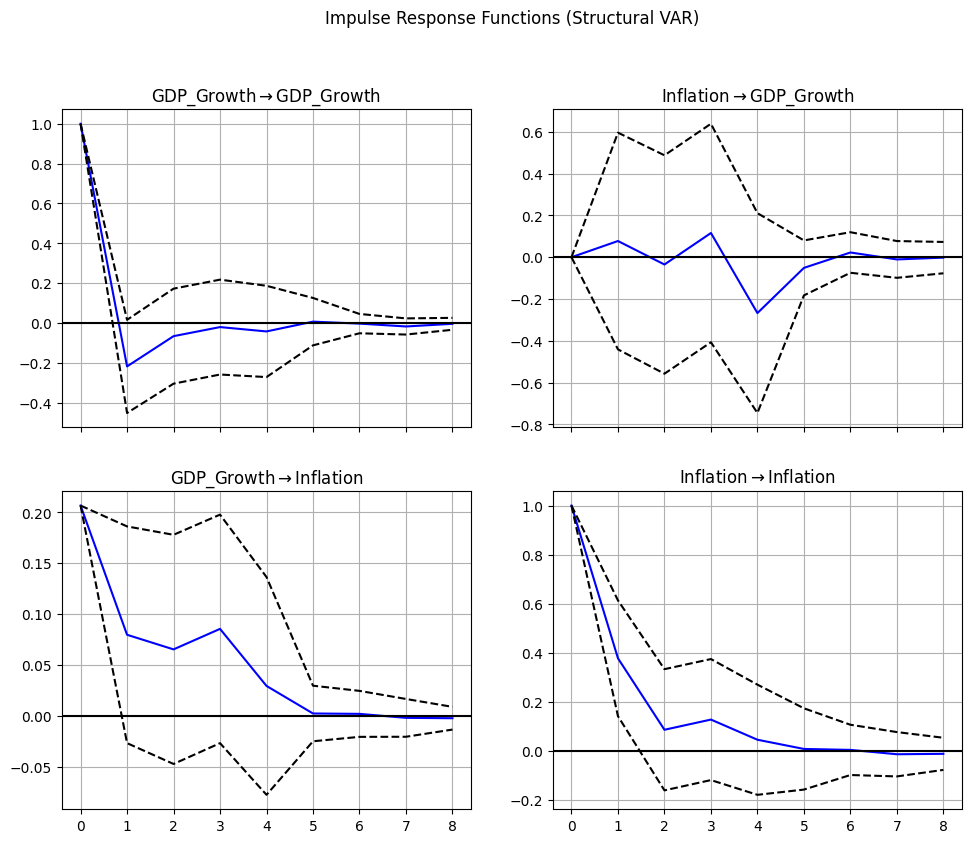

In [9]:
# Impulse Response Functions for SVAR
svar_irf = svar_results.irf(8)
fig = svar_irf.plot(orth=False, figsize=(10, 8))
# Add grid to all subplots
for ax in fig.axes:
    ax.grid(True)
plt.suptitle("Impulse Response Functions (Structural VAR)", y=1.05)
plt.show()

# VARX model

In a VARX model, the endogenous variables ($y_t$) are modeled as a function of their own lagged values, the lagged values of other endogenous variables, and both the current and lagged values of exogenous variables ($x_t$). The general form for a VARX(p, q) model, with $p$ lags of endogenous variables and $q$ lags of exogenous variables, is:

$$ y_t = c + \sum_{i=1}^p \Phi_i y_{t-i} + \sum_{j=0}^q \Gamma_j x_{t-j} + \epsilon_t $$

where:





$y_t$: Vector of endogenous variables at time $t$ (e.g., GDP_Growth, Inflation).



$x_t$: Vector of exogenous variables at time $t$ (e.g., FEDFUNDS).



$c$: Vector of constant terms.



$\Phi_i$: Coefficient matrices for lagged endogenous variables.



$\Gamma_j$: Coefficient matrices for current and lagged exogenous variables.



$\epsilon_t$: Vector of error terms (assumed to have zero mean and covariance matrix $\Sigma$).

In [10]:
# Fit VARX model
var_model = VAR(endog_data, exog=exog_data)
var_results = var_model.fit(maxlags=4)
var_results.summary()

c:\Users\manuz\Desktop\Adm\Projects\VAR_Python\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Aug, 2025
Time:                     22:01:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0197790
Nobs:                     95.0000    HQIC:                 -0.300625
Log likelihood:          -224.999    FPE:                   0.596716
AIC:                    -0.517879    Det(Omega_mle):        0.488468
--------------------------------------------------------------------
Results for equation GDP_Growth
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.833622         0.254850            3.271           0.001
FEDFUNDS              0.069945         0.082274            0.850           0.395
L1.GDP_Growth        -0.238883         0.119595        

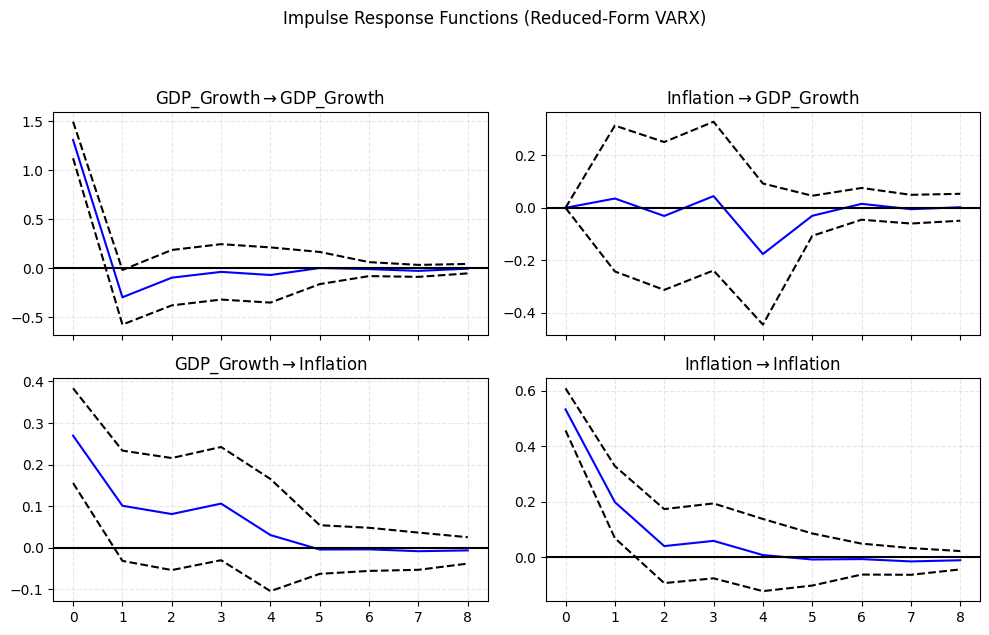

In [11]:
# Plot reduced-form IRFs
fig = var_results.irf(8).plot(orth=True, figsize=(10, 6))
for ax in fig.axes:
    ax.grid(True, linestyle='--', alpha=0.3)  # Dashed grid
fig.suptitle("Impulse Response Functions (Reduced-Form VARX)", y=1.05)
fig.tight_layout()
plt.show()

# Bayesian Vector Autoregression (BVAR)

- **Model Structure**: Similar to VAR, BVAR models endogenous variables ($y_t$) as functions of their own lags and, optionally, exogenous variables ($x_t$):
  $$
  y_t = c + \sum_{i=1}^p \Phi_i y_{t-i} + \sum_{j=0}^q \Gamma_j x_{t-j} + \epsilon_t
 $$
  where $y_t$ (e.g., `GDP_Growth`, `Inflation`) depends on lagged values and exogenous variables (e.g., `FEDFUNDS`), and $\epsilon_t \sim N(0, \Sigma)$.
- **Bayesian Estimation**: Priors (e.g., Minnesota prior) shrink coefficients toward zero or random walk behavior, reducing parameter uncertainty and improving forecast stability.
- **IRFs**: Impulse Response Functions (IRFs) can be computed for endogenous variable shocks, incorporating exogenous variable effects, similar to VARX.
- **Advantages**: Handles small datasets better, avoids overfitting, and provides uncertainty measures (e.g., credible intervals) for coefficients and IRFs.

In [ ]:
# Prepare data for BVAR
n_lags = 4
y = endog_data.values
x = exog_data.values
n_vars = y.shape[1]
T = y.shape[0]

# Create lagged endogenous variables
y_lagged = []
for lag in range(1, n_lags + 1):
    y_lagged.append(y[n_lags-lag:T-lag])
y_lagged = np.hstack(y_lagged)
y_dependent = y[n_lags:]

# Combine exogenous and lagged endogenous for regressors
X = np.hstack([np.ones((T-n_lags, 1)), x[n_lags:], y_lagged])  # Include intercept

# Debugging: Check shapes
print("y_dependent shape:", y_dependent.shape)
print("X shape:", X.shape)

In [ ]:
# BVAR model with PyMC
with pm.Model() as bvar_model:
    # Priors (Minnesota-like: mean 0, small variance for coefficients)
    lag_coefs = pm.Normal('lag_coefs', mu=0, sigma=0.1, shape=(n_vars, X.shape[1]))
    sigma = pm.HalfNormal('sigma', sigma=1, shape=n_vars)
    
    # Construct diagonal covariance matrix using pytensor
    cov_matrix = pt.diag(sigma**2)
    
    # Linear combination
    mu = pm.math.dot(X, lag_coefs.T)
    
    # Likelihood (multivariate normal)
    pm.MvNormal('likelihood', mu=mu, cov=cov_matrix, observed=y_dependent)
    
    # Sample from posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

y_dependent shape: (95, 2)
X shape: (95, 10)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag_coefs, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


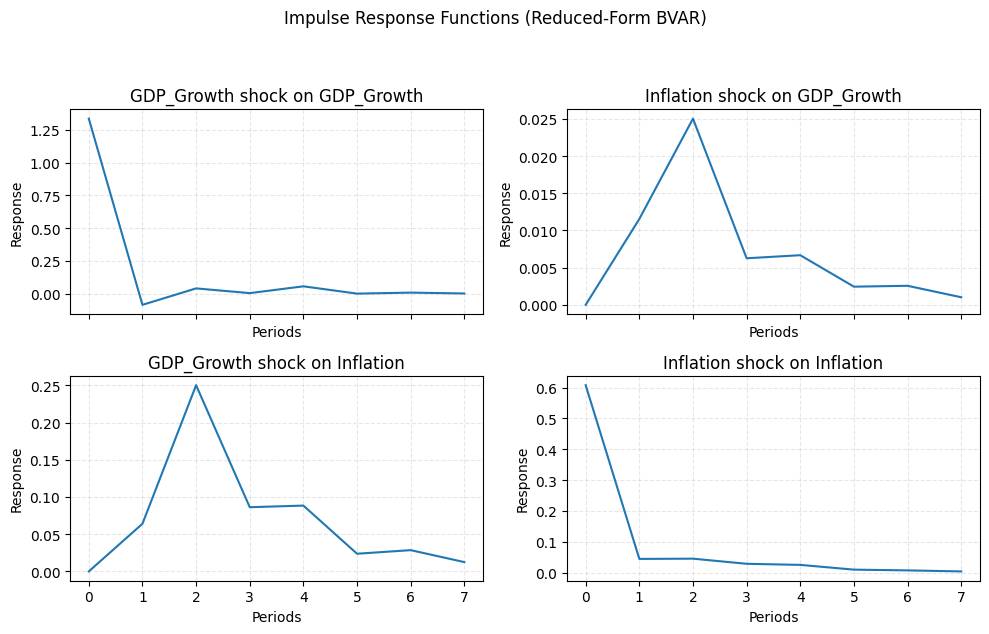

In [17]:
# Compute IRFs (reduced-form)
irf_periods = 8
irfs = np.zeros((irf_periods, n_vars, n_vars))
chol = np.linalg.cholesky(np.diag(az.summary(trace, var_names=['sigma'])['mean'].values**2))
coefs = az.summary(trace, var_names=['lag_coefs'])['mean'].values.reshape(n_vars, X.shape[1])[:, 1:]  # Exclude intercept
coefs = coefs[:, 1:]  # Exclude exogenous variable
coefs = coefs.reshape(n_vars, n_vars, n_lags)

for t in range(irf_periods):
    if t == 0:
        irfs[t] = chol
    else:
        for lag in range(min(t, n_lags)):
            irfs[t] += np.dot(coefs[:, :, lag], irfs[t-lag-1])

# Plot reduced-form IRFs with grid and separated suptitle
fig = plt.figure(figsize=(10, 6))
axes = fig.subplots(nrows=2, ncols=2, sharex=True)
irf_names = ['GDP_Growth', 'Inflation']
for i in range(2):
    for j in range(2):
        axes[i, j].plot(range(irf_periods), irfs[:, i, j])
        axes[i, j].set_title(f'{irf_names[j]} shock on {irf_names[i]}')
        axes[i, j].set_xlabel('Periods')
        axes[i, j].set_ylabel('Response')
        axes[i, j].grid(True, linestyle='--', alpha=0.3)  # Dashed grid
fig.suptitle("Impulse Response Functions (Reduced-Form BVAR)", y=1.05)
fig.tight_layout()
plt.show()